In [9]:
import numpy as np
import pandas as pd 
import numpy.random as rnd
import matplotlib.pyplot as plt
import time 

We need to import the following classes

In [10]:
from routines.cox_routines import cox_model
from routines.surv_data_generator import surv_models

First of all we generate a synthetic data-set. In order to do this we need to supply some infos. 

In [11]:
#number of covariates
p = 2000
#overfitting ratio
zeta = 2.0
#number of covariates
n = int(p / zeta)
#sparsity
delta = 0.01
#signal strength 
theta0 = 1.0

We now define a function to generate the isotropic covariance matrix $\bm{\Sigma}_0 := \bm{I}_p/p$ and the true vector of associations $\bm{\beta}_0$ as a sample from the standardized Gauss-Bernoulli distribution

In [12]:
def isotropic_setting(p, nu, theta0):
    beta0 = rnd.normal(size = p)* np.array(rnd.random(size = p)<nu, int)
    beta0 = beta0 / np.sqrt(beta0 @ beta0)
    beta0 = theta0 * np.sqrt(p) * beta0
    #generate covariance matrix
    Sigma0 = np.diag(np.ones(p))/p
    return Sigma0, beta0

#define the population covariance matrix and the true beta

Sigma0, beta0 = isotropic_setting(p, delta, theta0)

[ 0.  0.  0. ...  0. -0.  0.]


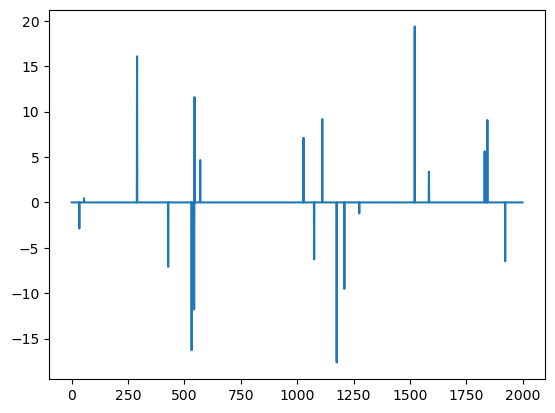

In [13]:
print(beta0)
plt.figure()
plt.plot(beta0)


We still need to provide the true cumulative hazard, or alternatively specify the survival anlaysis model from which to generate the survival times. At the moment, the class surv models allows to generate data from the 'log-logistic' or the 'weibull' models. Both require the specification of 2 parameters $\rho$ and $\phi$. We also need to specify the parameters of the censoring distribution. At the moment the class surv models allows to generate the censoring times from the uniform distribution only. It is required to pass the left end $\tau_1$ and the right end $\tau_2$ of the uniform distribution.

In [14]:
#define the true parameters of the cumulative hazard
phi0 = - np.log(2)
rho0 = 2.0
model = 'log-logistic'
#define the interval in which the censoring is uniform
tau1 = 1.0
tau2 = 2.0
#data generating process 
data_gen_process = surv_models(Sigma0, beta0, phi0, rho0, tau1, tau2, model) 

Now we can generate the data from the specified model

In [15]:
#generate data
T, C, X = data_gen_process.gen(n)

print('average number of events = ' +str(np.mean(C)))
print('average survival time = ' +str(np.mean(T)))


average number of events = 0.55
average survival time = 1.0793738699722386


We can now define the Cox model with the elastic net regularization 
$$
    {\rm r}(\bm{\beta}) = \alpha \rho \|\bm{\beta}\|_1 + \frac{1}{2} \alpha (1.0-\rho) \|\bm{\beta}\|_2^2
$$
as an instance of the class 'cox_model'.
We need to pass the coordinate of the regularization path: an array for the values of $\alpha$ and a fixed value for the ratio $\rho$.

In [16]:
#alpha values  
values = np.exp(np.linspace(np.log(10.0), np.log(0.5), 100))
#l1_ratio
ratio = 0.75
#fit the model along a regularization path
cox_m = cox_model(values, ratio)

We can now fit the Cox model along the pre-specified regularization path.
The method 'fit' takes as input the data T, C, X and the string method, which can be either 'amp', for the COX-AMP algorithm, or 'cd', for the Coordinate-wise Descent algorithm. The flag 'verb_flag' is a verbose flag.

In [17]:
import time
method = 'amp'
tic = time.time()
cox_m.fit(T, C, X, method)
toc = time.time()
print(' time elapsed = '+str((toc-tic)/60))

 time elapsed = 0.6955976565678914


Since we will compare the results of COX-AMP with the ones obtained with Coordinate-wise Descent,we save the quantities the betas along the path, and the train and test discrimination error.

In [18]:
#save the betas along the path and the flags of COX-AMP to see when the algorithm is not converged
betas_amp = cox_m.betas
flags_amp = cox_m.flags
#compute the discrimination error over the data used to fit the model
cox_m.compute_Harrel_c_train()
train_err_amp = cox_m.hc_index_train
#compute the discrimination error over a freshly generate data-set
T_test, C_test, X_test = data_gen_process.gen(n)
cox_m.compute_Harrel_c_test(T_test, C_test, X_test)
test_err_amp = cox_m.hc_index_test

We now repeat the same exact steps but with the method 'cd' for Coordinate-wise descent.

In [19]:
#fit with Cox CD
tic = time.time()
cox_m.fit(T, C, X, 'cd')
toc = time.time()
print(' time elapsed = '+str((toc-tic)/60))
betas_cd = cox_m.betas
cox_m.compute_Harrel_c_train()
train_err_cd = cox_m.hc_index_train
cox_m.compute_Harrel_c_test(T_test, C_test, X_test)
test_err_cd = cox_m.hc_index_test

 time elapsed = 0.41228952407836916


At this point we can visualize the realtive L2-distance
$$
    \|\hat{\bm{\beta}}_{amp} - \hat{\bm{\beta}}_{cd}\|_2  / \|\hat{\bm{\beta}}_{cd}\|_2
$$
between the estimators in a plot.  

Text(0.5, 0, '$\\alpha$')

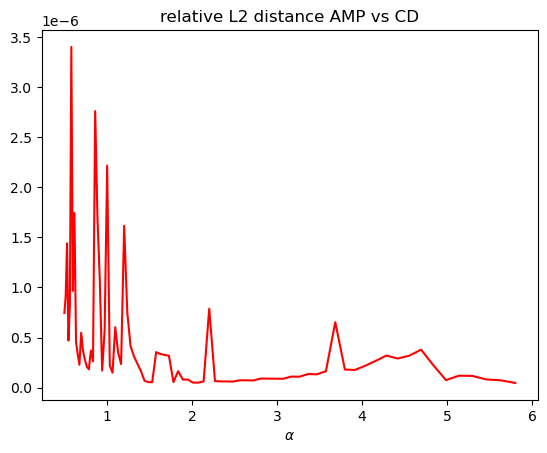

In [20]:
mse = np.sqrt(np.sum((betas_cd - betas_amp)**2, axis = 1))/ np.sqrt(np.sum((betas_cd)**2, axis = 1))
plt.figure()
plt.title('relative L2 distance AMP vs CD')
plt.plot(values, mse, 'r-')
plt.xlabel(r'$\alpha$')

Perhaps an Elbow plot is more eloquent.

Text(0.5, 0, '$\\alpha$')

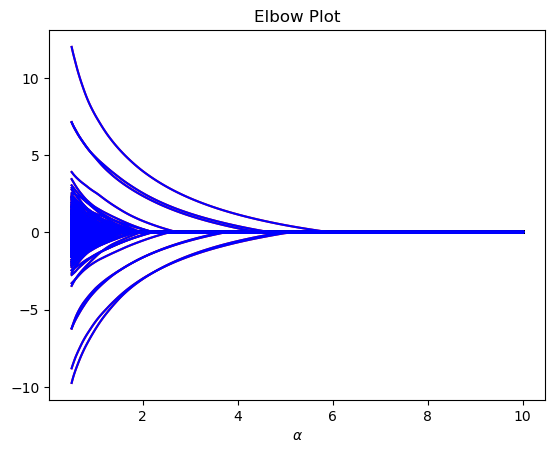

In [21]:
plt.figure()
plt.title('Elbow Plot')
plt.plot(values, betas_amp, 'r-')
plt.plot(values, betas_cd, 'b-')
for j in range(len(flags_amp)):
    if(flags_amp[j]!=True):
        plt.axvline(x = values[j])
plt.xlabel(r'$\alpha$')


Of course we can do the same thing for the train and test error, measured in term of C-index.

Text(0.5, 0, '$\\alpha$')

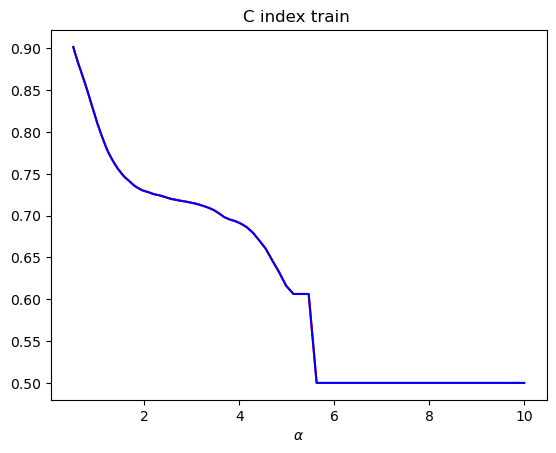

In [22]:
plt.figure()
plt.title('C index train ')
plt.plot(values, train_err_amp, 'r-')
plt.plot(values, train_err_cd, 'b-')
plt.xlabel(r'$\alpha$')

Text(0.5, 0, '$\\alpha$')

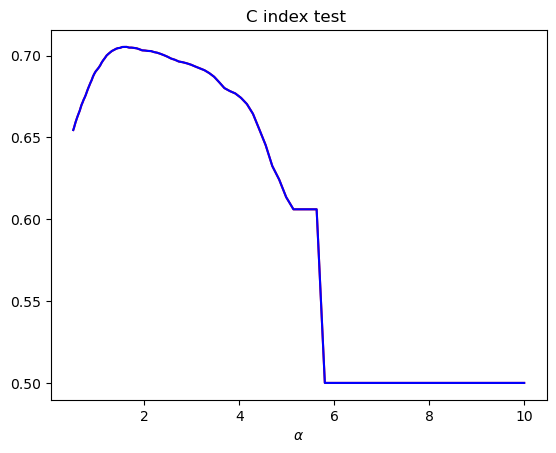

In [23]:
plt.figure()
plt.title('C index test ')
plt.plot(values, test_err_amp, 'r-')
plt.plot(values, test_err_cd, 'b-')
plt.xlabel(r'$\alpha$')